In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import os
from PIL import Image

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the dataset
image_dir = 'imgs/'
data_path = 'car_imgs_4000.csv'
df = pd.read_csv(data_path)

# Check the first few rows
print(df.head())


                                   filename  perspective_score_hood  \
0  66ee2d88-f403-4821-a370-8a3d72e200f9.jpg                 0.27352   
1  bf7e237e-f12b-4ffc-8d79-6855cc35ea06.jpg                 0.00000   
2  4c297488-c81f-464d-92bf-1c408333a912.jpg                 0.00000   
3  6c95ad0b-fda6-42a8-a33d-b430073e1dcd.jpg                 0.00000   
4  bd806d94-4c2e-4cd2-8e02-5eaba7c7c63e.jpg                 0.00000   

   perspective_score_backdoor_left  
0                         0.439526  
1                         0.902682  
2                         0.900864  
3                         0.213162  
4                         0.818388  


filename                           0
perspective_score_hood             0
perspective_score_backdoor_left    0
dtype: int64
       perspective_score_hood  perspective_score_backdoor_left
count             4000.000000                      4000.000000
mean                 0.303032                         0.313368
std                  0.382582                         0.372334
min                  0.000000                         0.000000
25%                  0.000000                         0.000000
50%                  0.000000                         0.000000
75%                  0.771014                         0.686797
max                  0.922428                         0.939541


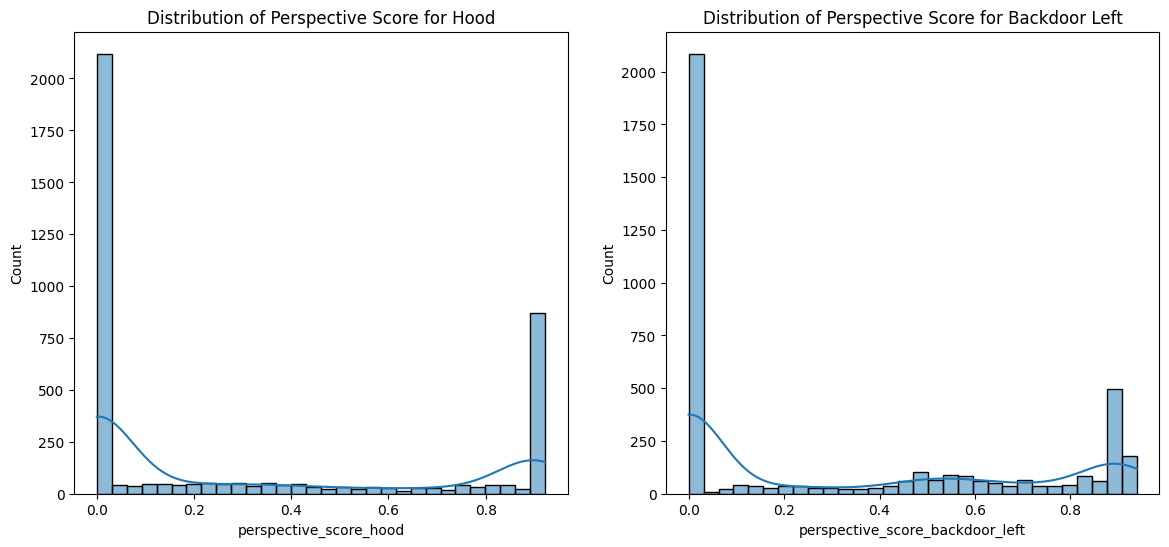

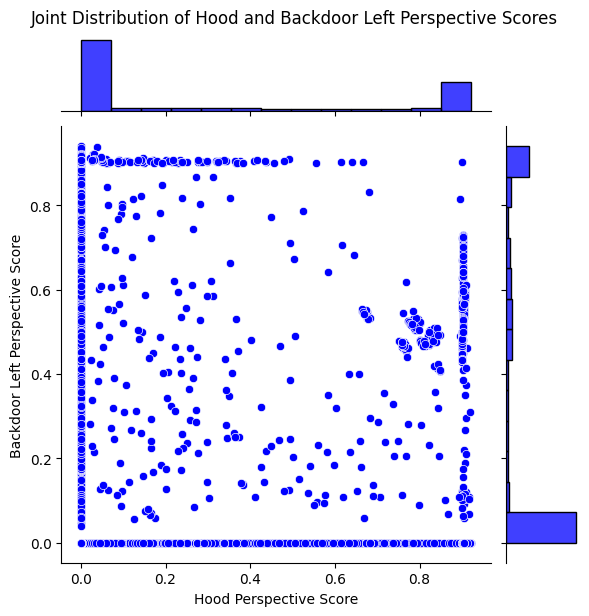

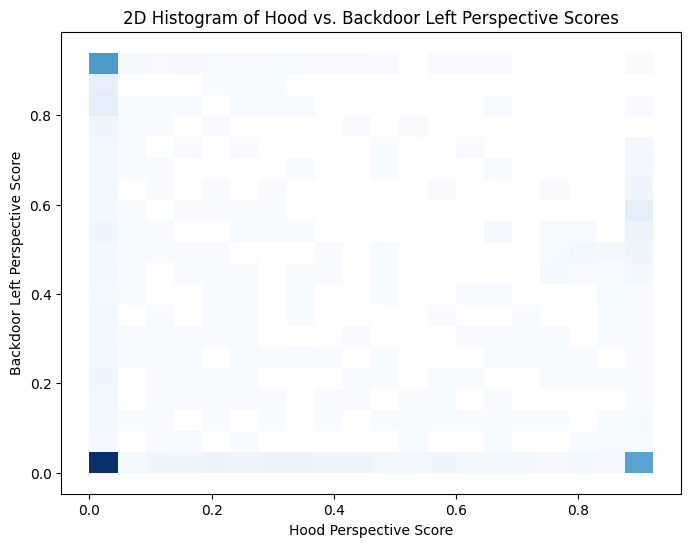

In [2]:
# Check for missing values
print(df.isnull().sum())

# Summary statistics of perspective scores
print(df.describe())

# Visualize the distribution of perspective scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['perspective_score_hood'], kde=True, bins=30)
plt.title('Distribution of Perspective Score for Hood')

plt.subplot(1, 2, 2)
sns.histplot(df['perspective_score_backdoor_left'], kde=True, bins=30)
plt.title('Distribution of Perspective Score for Backdoor Left')

plt.show()

# Plot the joint distribution of the two perspective scores
sns.jointplot(x='perspective_score_hood', y='perspective_score_backdoor_left', data=df, kind='scatter', color='blue')

plt.suptitle('Joint Distribution of Hood and Backdoor Left Perspective Scores', y=1.02)
plt.xlabel('Hood Perspective Score')
plt.ylabel('Backdoor Left Perspective Score')
plt.show()

# plot a heatmap of two variables
plt.figure(figsize=(8, 6))
sns.histplot(x='perspective_score_hood', y='perspective_score_backdoor_left', data=df, bins=20, pmax=.8, cmap="Blues")

plt.title('2D Histogram of Hood vs. Backdoor Left Perspective Scores')
plt.xlabel('Hood Perspective Score')
plt.ylabel('Backdoor Left Perspective Score')
plt.show()

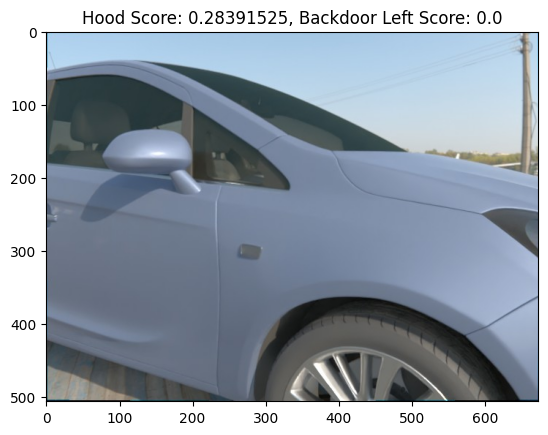

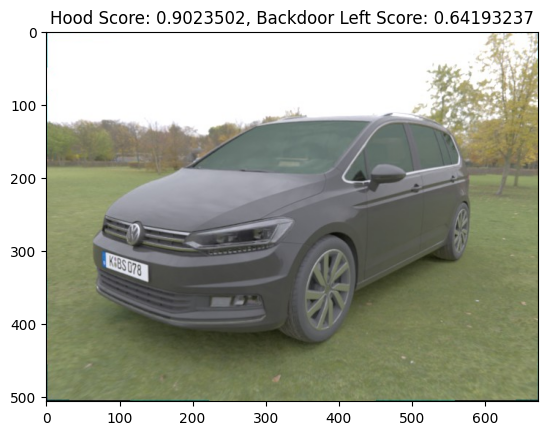

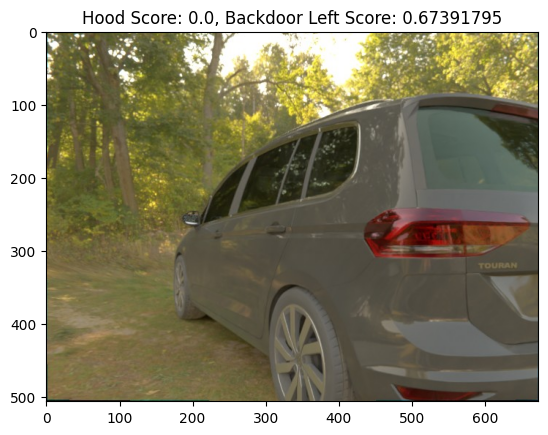

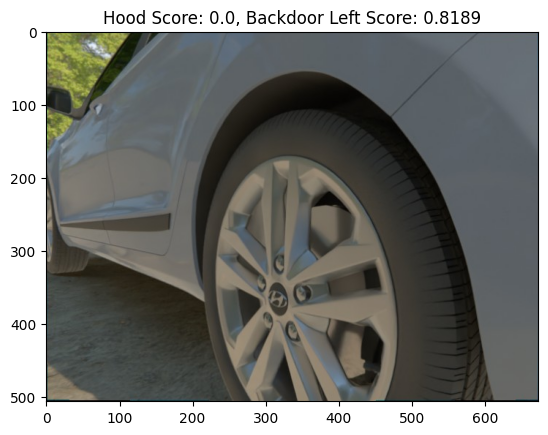

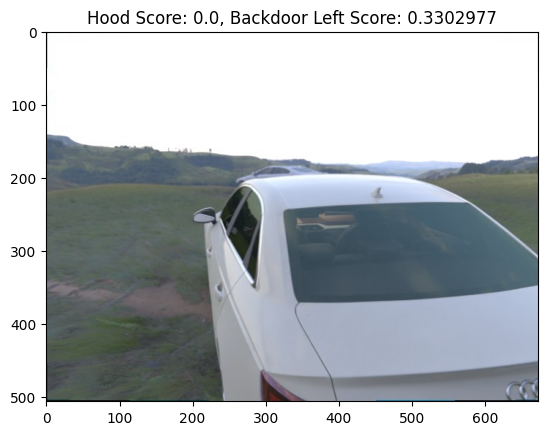

In [3]:
# Load and display sample images from different score ranges
sample_images = df.sample(5)
for index, row in sample_images.iterrows():
    image_path = os.path.join(image_dir, row['filename'])
    image = read_image(image_path)
    plt.imshow(image.permute(1, 2, 0))  # Change tensor dimensions for plotting
    plt.title(f"Hood Score: {row['perspective_score_hood']}, Backdoor Left Score: {row['perspective_score_backdoor_left']}")
    plt.show()

In [4]:
# Define a function to load images and convert them to grayscale
def load_images(image_paths, image_dir, sample_size=100):
    images = []
    for filename in image_paths[:sample_size]:
        img = Image.open(os.path.join(image_dir, filename)).convert('L')  # Convert to grayscale
        images.append(np.array(img))
    return images

# Sample image paths (e.g., first 100 images)
sample_size = 1000
sample_image_paths = df['filename'].values

# Load the images
images = load_images(sample_image_paths, image_dir, sample_size=sample_size)

max intensity: 255, min intensity: 0


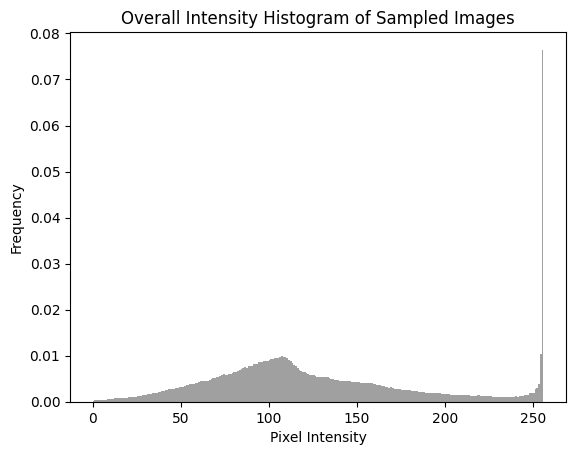

In [5]:
# Flatten all images and concatenate to create a single array of intensities
intensities = np.concatenate([img.flatten() for img in images])

print(f'max intensity: {np.max(intensities)}, min intensity: {np.min(intensities)}')
# Plot the overall intensity histogram
plt.figure()
plt.hist(intensities, bins=256, range=(0, 256), density=True, color='gray', alpha=0.75)
plt.title('Overall Intensity Histogram of Sampled Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


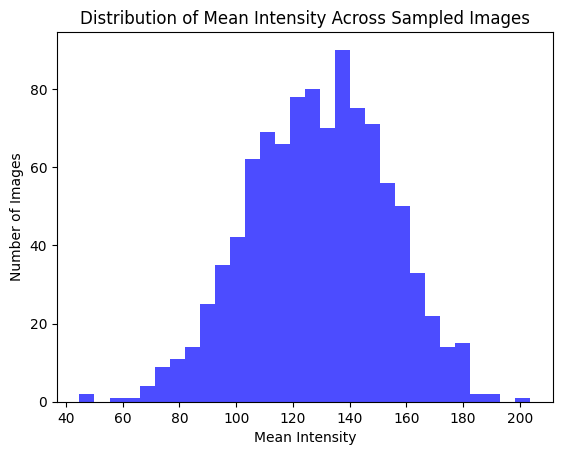

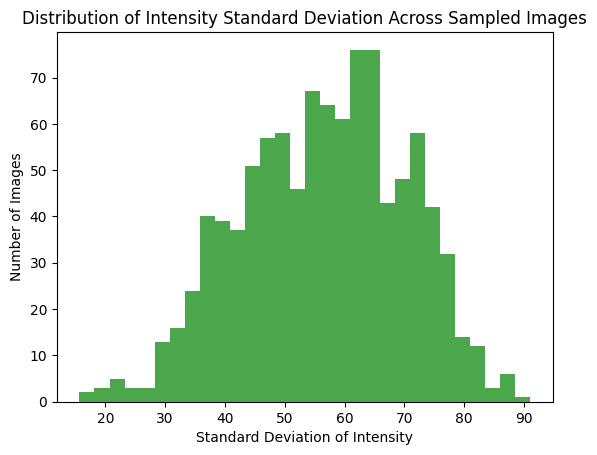

In [6]:
# Compute statistics for each image
means = [np.mean(img) for img in images]
std_devs = [np.std(img) for img in images]

# Visualize the mean intensity distribution
plt.figure()
plt.hist(means, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Mean Intensity Across Sampled Images')
plt.xlabel('Mean Intensity')
plt.ylabel('Number of Images')
plt.show()

# Visualize the standard deviation distribution
plt.figure()
plt.hist(std_devs, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Intensity Standard Deviation Across Sampled Images')
plt.xlabel('Standard Deviation of Intensity')
plt.ylabel('Number of Images')
plt.show()


In [7]:
# Define a function to extract image sizes
def extract_image_sizes(image_paths, image_dir, sample_size=100):
    widths = []
    heights = []
    for filename in image_paths[:sample_size]:
        with Image.open(os.path.join(image_dir, filename)) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    return widths, heights

# Extract image sizes
widths, heights = extract_image_sizes(sample_image_paths, image_dir, sample_size=sample_size)

# Calculate aspect ratios
aspect_ratios = [width / height for width, height in zip(widths, heights)]


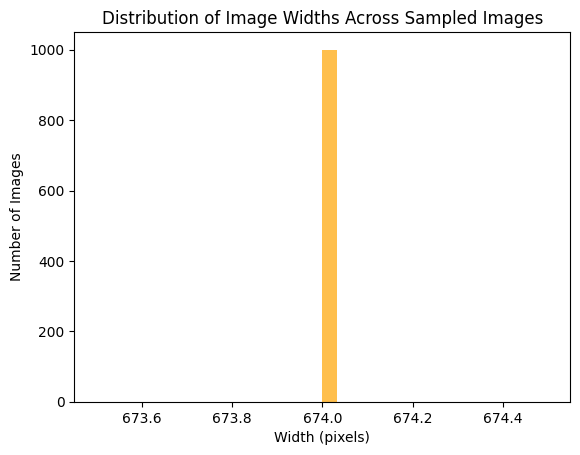

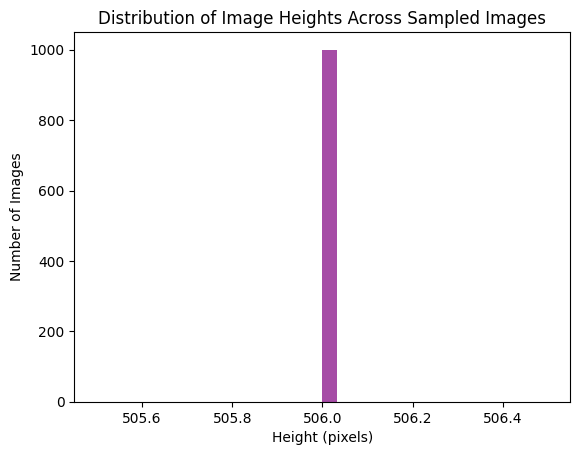

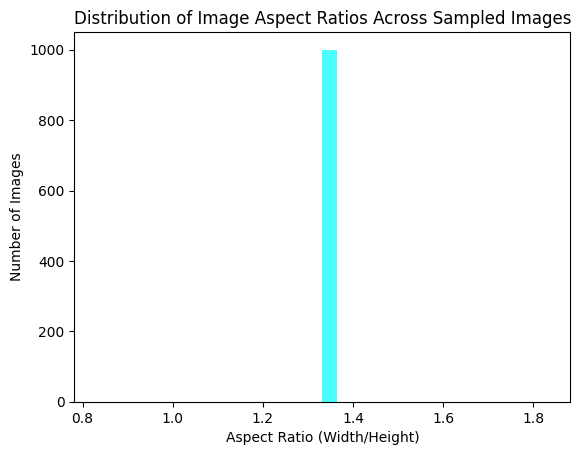

In [8]:
# Plot the distribution of image widths
plt.figure()
plt.hist(widths, bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Image Widths Across Sampled Images')
plt.xlabel('Width (pixels)')
plt.ylabel('Number of Images')
plt.show()

# Plot the distribution of image heights
plt.figure()
plt.hist(heights, bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Heights Across Sampled Images')
plt.xlabel('Height (pixels)')
plt.ylabel('Number of Images')
plt.show()

# Plot the distribution of image aspect ratios
plt.figure()
plt.hist(aspect_ratios, bins=30, color='cyan', alpha=0.7)
plt.title('Distribution of Image Aspect Ratios Across Sampled Images')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Number of Images')
plt.show()


In [3]:
# stratified data split
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the number of bins
num_bins = 4

# Discretize the labels
df['hood_bin'] = pd.cut(df['perspective_score_hood'], bins=num_bins, labels=False)
df['backdoor_bin'] = pd.cut(df['perspective_score_backdoor_left'], bins=num_bins, labels=False)

# Create a joint label group
df['joint_bin'] = df['hood_bin'].astype(str) + '_' + df['backdoor_bin'].astype(str)

print(df.head())
# Perform the stratified split based on the joint distribution
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['joint_bin'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['joint_bin'])


                                   filename  perspective_score_hood  \
0  66ee2d88-f403-4821-a370-8a3d72e200f9.jpg                 0.27352   
1  bf7e237e-f12b-4ffc-8d79-6855cc35ea06.jpg                 0.00000   
2  4c297488-c81f-464d-92bf-1c408333a912.jpg                 0.00000   
3  6c95ad0b-fda6-42a8-a33d-b430073e1dcd.jpg                 0.00000   
4  bd806d94-4c2e-4cd2-8e02-5eaba7c7c63e.jpg                 0.00000   

   perspective_score_backdoor_left  hood_bin  backdoor_bin joint_bin  
0                         0.439526         1             1       1_1  
1                         0.902682         0             3       0_3  
2                         0.900864         0             3       0_3  
3                         0.213162         0             0       0_0  
4                         0.818388         0             3       0_3  


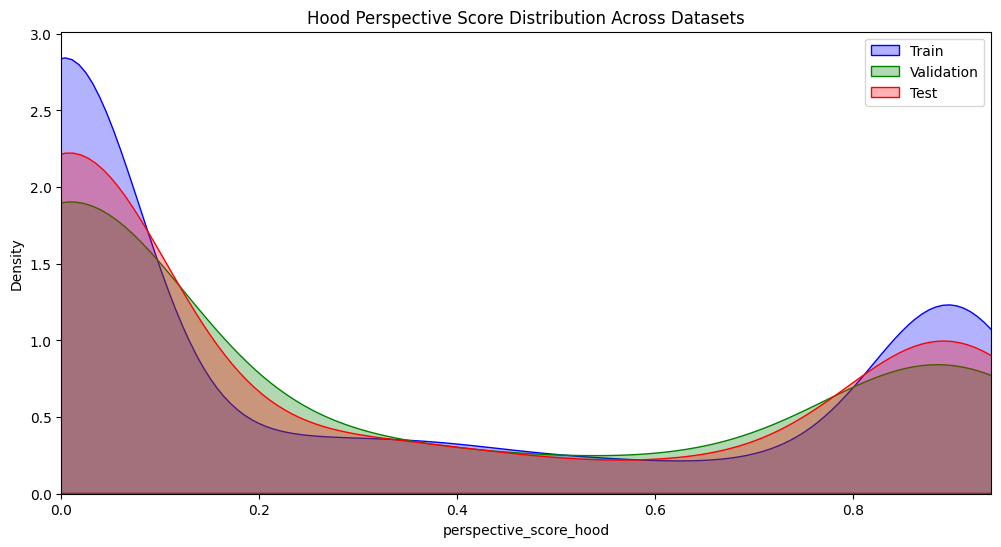

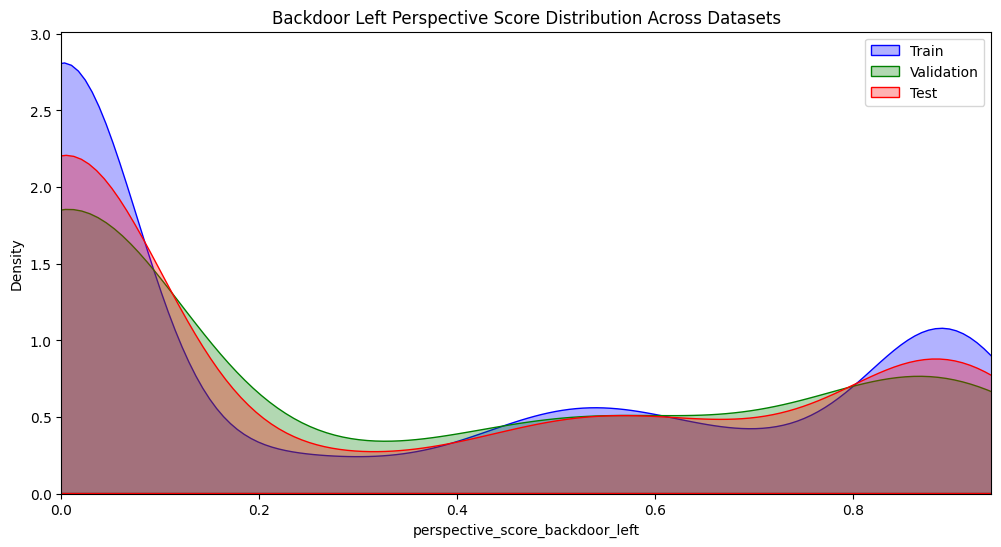

In [10]:
# Determine the common x-axis limits (min and max of the perspective scores across the whole dataset)
x_min = min(df['perspective_score_hood'].min(), df['perspective_score_backdoor_left'].min())
x_max = max(df['perspective_score_hood'].max(), df['perspective_score_backdoor_left'].max())

# Estimate the maximum density (y-axis) by plotting all KDEs and finding the max density value
y_max_hood = sns.kdeplot(df['perspective_score_hood']).get_lines()[0].get_data()[1].max()
y_max_backdoor = sns.kdeplot(df['perspective_score_backdoor_left']).get_lines()[0].get_data()[1].max()

y_max = max(y_max_hood, y_max_backdoor)  # Set the y-axis limit as the maximum of these
plt.close()  # Close these temporary plots

# Function to plot KDE for the datasets with consistent axis limits
def plot_kde_distribution(train_df, val_df, test_df, column_name, title, x_limits, y_limit):
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(train_df[column_name], label='Train', color='blue', fill=True, alpha=0.3)
    sns.kdeplot(val_df[column_name], label='Validation', color='green', fill=True, alpha=0.3)
    sns.kdeplot(test_df[column_name], label='Test', color='red', fill=True, alpha=0.3)
    
    plt.title(f'{title} Distribution Across Datasets')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.xlim(x_limits)
    plt.ylim(0, y_limit)
    plt.legend()
    plt.show()

# Apply consistent axis limits to the plots
x_limits = (x_min, x_max)

# Plot distributions for perspective_score_hood
plot_kde_distribution(train_df, val_df, test_df, 'perspective_score_hood', 'Hood Perspective Score', x_limits, y_max)

# Plot distributions for perspective_score_backdoor_left
plot_kde_distribution(train_df, val_df, test_df, 'perspective_score_backdoor_left', 'Backdoor Left Perspective Score', x_limits, y_max)


x-axis limits: (0.0, 0.9395413)
y-axis limits: (0.0, 0.9395413)


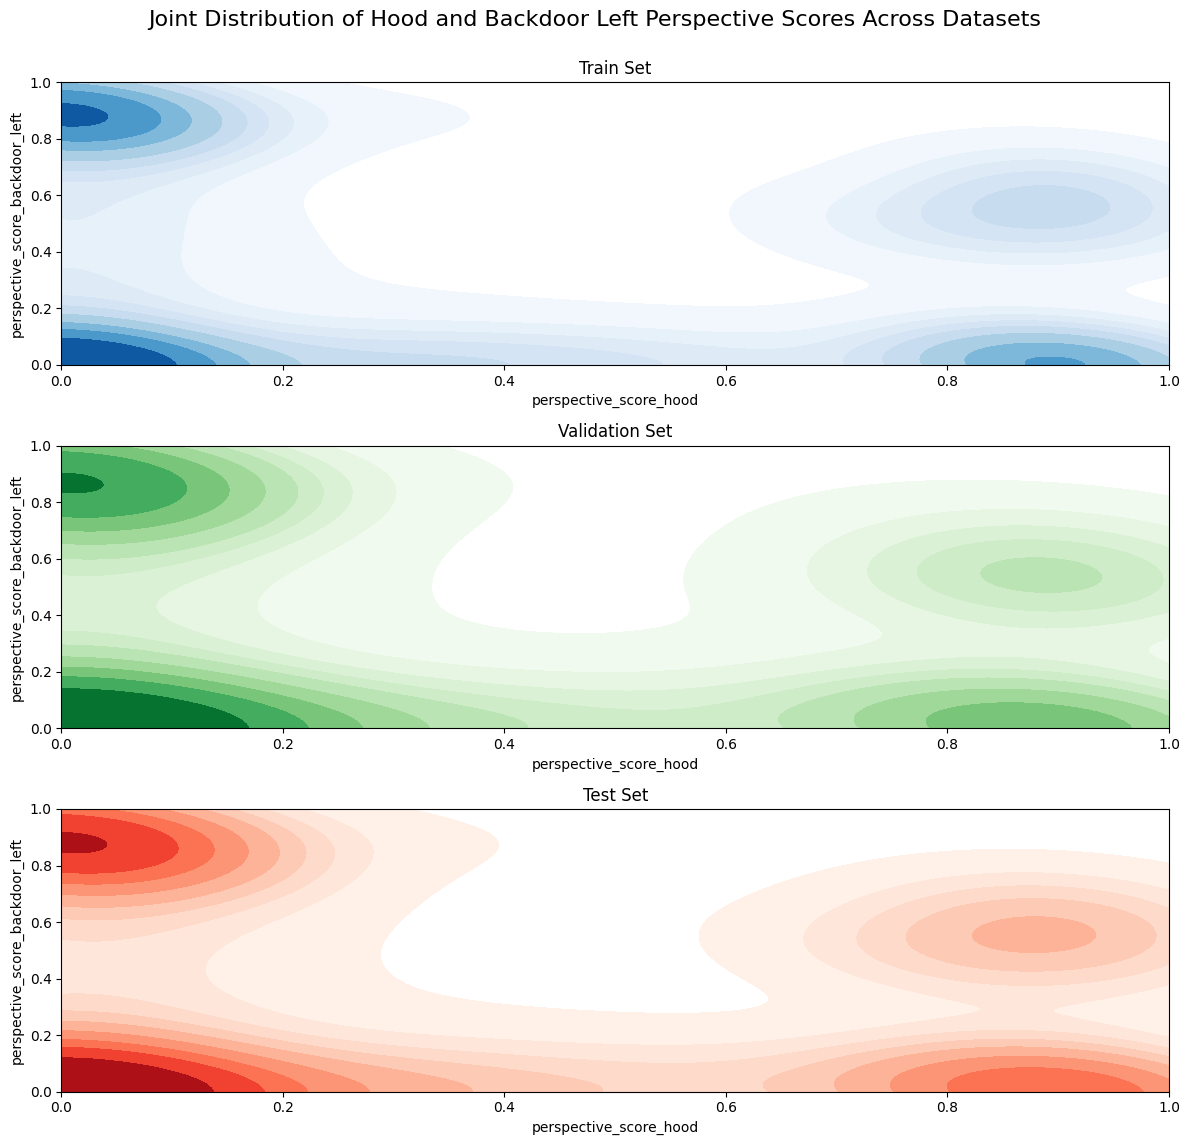

In [11]:
# Determine the common x-axis and y-axis limits (min and max of the perspective scores across the whole dataset)
x_min = df[['perspective_score_hood', 'perspective_score_backdoor_left']].min().min()
x_max = df[['perspective_score_hood', 'perspective_score_backdoor_left']].max().max()

# Set y-axis limits based on the same range as x-axis to maintain square plots
y_limits = (x_min, x_max)

# Print the determined limits
print(f"x-axis limits: ({x_min}, {x_max})")
print(f"y-axis limits: {y_limits}")

# Function to plot joint distribution with fixed axis limits between 0 and 1
def plot_joint_distribution(train_df, val_df, test_df, x_column, y_column, title):
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Joint Distribution of {title} Across Datasets', y=0.95, fontsize=16)

    # Define the fixed axis limits
    x_limits = (0, 1)
    y_limits = (0, 1)

    # Training set
    plt.subplot(3, 1, 1)
    sns.kdeplot(x=train_df[x_column], y=train_df[y_column], cmap='Blues', fill=True)
    plt.title('Train Set')
    plt.xlim(x_limits)
    plt.ylim(y_limits)

    # Validation set
    plt.subplot(3, 1, 2)
    sns.kdeplot(x=val_df[x_column], y=val_df[y_column], cmap='Greens', fill=True)
    plt.title('Validation Set')
    plt.xlim(x_limits)
    plt.ylim(y_limits)

    # Test set
    plt.subplot(3, 1, 3)
    sns.kdeplot(x=test_df[x_column], y=test_df[y_column], cmap='Reds', fill=True)
    plt.title('Test Set')
    plt.xlim(x_limits)
    plt.ylim(y_limits)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot the joint distribution for Hood and Backdoor Left perspective scores with fixed axis limits
plot_joint_distribution(train_df, val_df, test_df, 'perspective_score_hood', 'perspective_score_backdoor_left', 
                        'Hood and Backdoor Left Perspective Scores')

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import os
from PIL import Image

class CarDamageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        hood_score = self.dataframe.iloc[idx, 1]
        backdoor_score = self.dataframe.iloc[idx, 2]
        labels = torch.tensor([hood_score, backdoor_score], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels


In [5]:
import torchvision.transforms as transforms

# Define transformations for training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    # transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    # transforms.RandomRotation(10),  # Apply random rotation
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet standards
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet standards
])


In [6]:
# Create dataset objects for train, validation, and test sets
train_dataset = CarDamageDataset(train_df, image_dir, transform=train_transform)
val_dataset = CarDamageDataset(val_df, image_dir, transform=val_test_transform)
test_dataset = CarDamageDataset(test_df, image_dir, transform=val_test_transform)

In [7]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


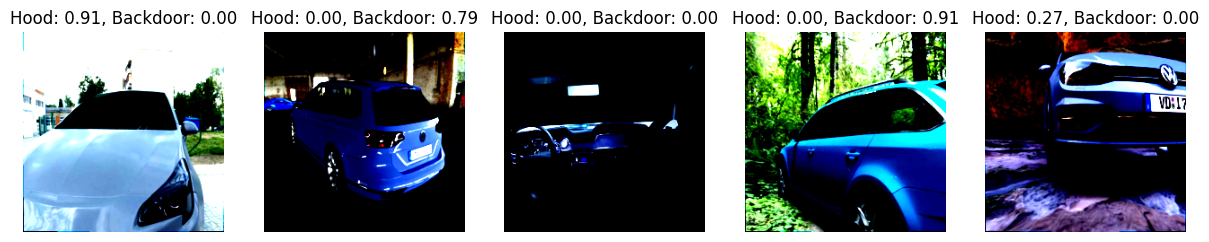

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize preprocessed images and their labels
def visualize_preprocessed_samples(loader, num_samples=5):
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    
    images = images.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C) for plotting
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])  # Display the preprocessed image
        plt.title(f'Hood: {labels[i][0]:.2f}, Backdoor: {labels[i][1]:.2f}')
        plt.axis('off')
    plt.show()

# Visualize preprocessed samples from the training loader
visualize_preprocessed_samples(val_loader, num_samples=5)


In [10]:
# Function to print the min and max pixel values of exactly 5 preprocessed images
def print_preprocessed_image_min_max(loader, num_samples=5):
    images, _ = next(iter(loader))
    
    # Take only the first 5 samples
    images = images[:num_samples]
    
    min_val = images.min().item()
    max_val = images.max().item()
    
    print(f'Min pixel value: {min_val}')
    print(f'Max pixel value: {max_val}')

# Check the min and max pixel values in the training loader for 5 samples
print_preprocessed_image_min_max(train_loader, num_samples=5)


Min pixel value: -2.0836544036865234
Max pixel value: 2.640000104904175


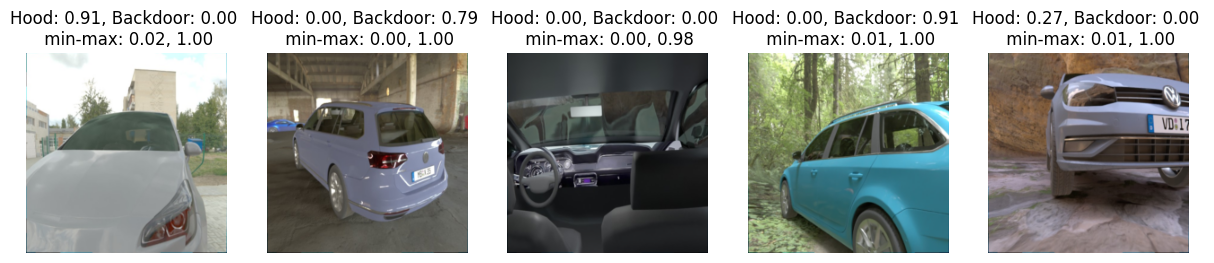

In [11]:
import matplotlib.pyplot as plt

# Function to visualize images and their labels
def visualize_samples(loader, num_samples=5):
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    
    # Denormalize images for visualization (reversing the normalization)
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    images = images * std + mean
    
    images = images.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C) for plotting
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f'Hood: {labels[i][0]:.2f}, Backdoor: {labels[i][1]:.2f} \n min-max: {np.min(images[i]):.2f}, {np.max(images[i]):.2f}')
        plt.axis('off')
    plt.show()

# Visualize samples from the validation loader
visualize_samples(val_loader, num_samples=5)


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet18 model
model = models.resnet50(pretrained=True)

# Freeze all layers except the last conv block (layer4) and the fully connected layer (fc)
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Print the model architecture to confirm which layers are frozen (optional)
print(model)

# Replace the final fully connected layer for regression (outputting 2 scores for your task)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


D:\anaconda3\envs\code_challenge\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\code_challenge\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Define the loss function (e.g., MSE Loss for regression)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam optimize
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# Define your optimizer, make sure it only optimizes the trainable parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)


In [14]:
# Set the number of epochs
num_epochs = 15
best_val_loss = float('inf')  # Initialize with infinity to ensure any validation loss is lower

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Validation loop to delve into the model's performance
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")
    
    # Check if this is the best model we've encountered in this intricate mosaic of training epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        best_model_path = f'resnet50_finetune_best_model_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), best_model_path)  # Save the best model weights immediately
        print(f"Best model updated and saved with validation loss: {best_val_loss} at epoch {epoch+1}")

# After training is complete, the best model's weights will have already been saved
print(f"Training complete. Best model saved as {best_model_path} with validation loss: {best_val_loss}")


Epoch 1/15, Loss: 0.1282305558005141
Validation Loss: 0.027127761766314505
Best model updated and saved with validation loss: 0.027127761766314505 at epoch 1
Epoch 2/15, Loss: 0.02631845951287283
Validation Loss: 0.0384458439424634
Epoch 3/15, Loss: 0.016332937435557447
Validation Loss: 0.032043441012501714
Epoch 4/15, Loss: 0.015531330421153042
Validation Loss: 0.04470732528716326
Epoch 5/15, Loss: 0.01491905624150402
Validation Loss: 0.051993004977703094
Epoch 6/15, Loss: 0.012190334421272079
Validation Loss: 0.03567870408296585
Epoch 7/15, Loss: 0.012516828207299113
Validation Loss: 0.028935395739972593
Epoch 8/15, Loss: 0.011532458838903241
Validation Loss: 0.029684907384216787
Epoch 9/15, Loss: 0.01275742400644554
Validation Loss: 0.02286814795807004
Best model updated and saved with validation loss: 0.02286814795807004 at epoch 9
Epoch 10/15, Loss: 0.012534870228005781
Validation Loss: 0.027264108881354332
Epoch 11/15, Loss: 0.01353442683402035
Validation Loss: 0.0220104066655039

In [13]:
# Load the model architecture
model = models.resnet18(pretrained=False)

# Replace the final fully connected layer to match the architecture used during training
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming the output is 2 values

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the best model weights
best_model_path = 'resnet18_finetune_best_model_epoch_5.pth'  # Replace X with the appropriate epoch number
model.load_state_dict(torch.load(best_model_path))

# Test the model
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader)}")


C:\Users\rajan\AppData\Local\Temp\ipykernel_15436\1742867234.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.021337128728628158


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to evaluate the model
def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    preds = []
    targets = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    preds = np.array(preds)
    targets = np.array(targets)
    
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    r2 = r2_score(targets, preds)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    
    return preds, targets

# Evaluate on the test set
preds, targets = evaluate_model(model, test_loader)


Mean Absolute Error (MAE): 0.10882389545440674
Root Mean Squared Error (RMSE): 0.14607234299182892
R² Score: 0.8493993282318115


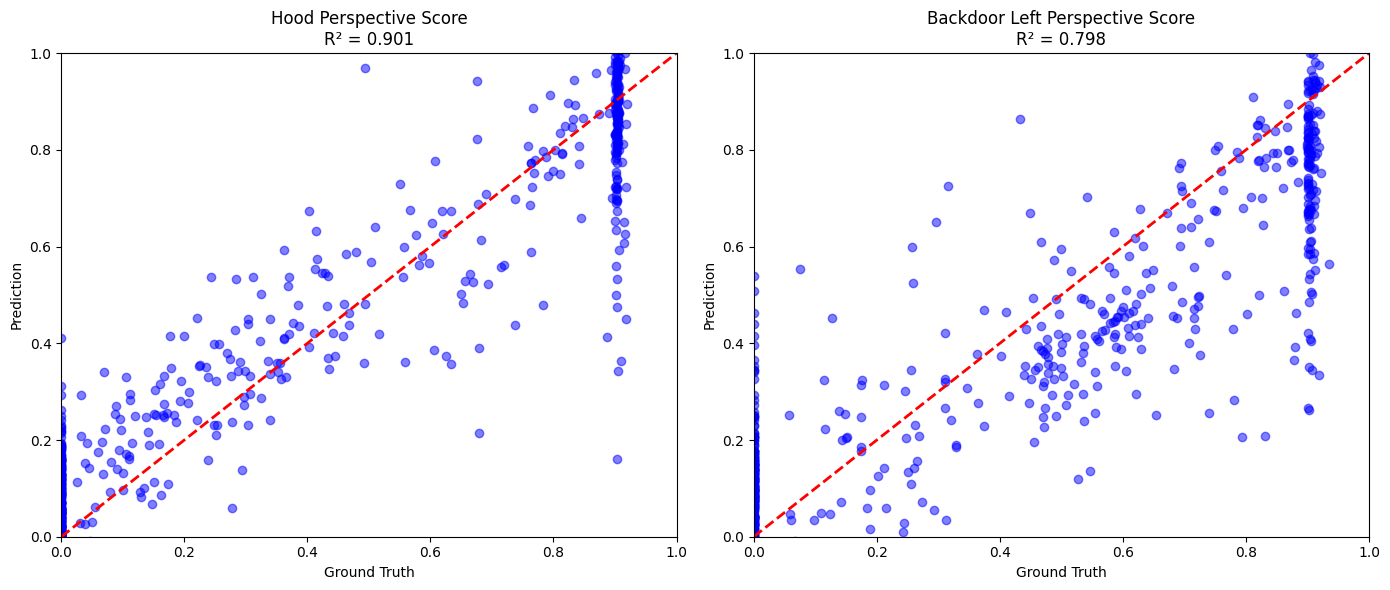

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Function to create scatter plots with R² value for each variable
def plot_scatter_with_r2(preds, targets, labels):
    plt.figure(figsize=(14, 6))

    for i, label in enumerate(labels):
        plt.subplot(1, 2, i + 1)
        plt.scatter(targets[:, i], preds[:, i], alpha=0.5, color='blue')
        plt.plot([0, 1], [0, 1], '--', color='red', linewidth=2)  # Diagonal line for reference
        r2 = r2_score(targets[:, i], preds[:, i])
        plt.title(f'{label}\nR² = {r2:.3f}')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.xlim(0, 1)
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Labels for the variables
labels = ['Hood Perspective Score', 'Backdoor Left Perspective Score']

# Plot scatter plots with R² values
plot_scatter_with_r2(preds, targets, labels)



In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to bin predictions and targets into 5 classes
def bin_labels(labels, num_bins=5):
    bins = np.linspace(0, 1, num_bins + 1)  # Create bins from 0 to 1
    return np.digitize(labels, bins) - 1  # digitize returns bins starting from 1, subtract 1 to make it 0-indexed

# Bin the true labels and predictions for the first output
true_labels_binned_1 = bin_labels(targets[:, 0])  # Binning based on the first output
predictions_binned_1 = bin_labels(preds[:, 0])

print(np.min(preds), np.max(preds))
print(np.min(true_labels_binned_1), np.max(true_labels_binned_1), np.min(predictions_binned_1), np.max(predictions_binned_1))

# Bin the true labels and predictions for the second output
true_labels_binned_2 = bin_labels(targets[:, 1])  # Binning based on the second output
predictions_binned_2 = bin_labels(preds[:, 1])

# Generate classification report for the first output
print("Classification Report for Output 1:")
report_1 = classification_report(true_labels_binned_1, predictions_binned_1, target_names=[f'Class {i}' for i in range(5)])
print(report_1)

# Generate confusion matrix for the first output
conf_matrix_1 = confusion_matrix(true_labels_binned_1, predictions_binned_1)
ConfusionMatrixDisplay(conf_matrix_1, display_labels=[f'Class {i}' for i in range(5)]).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Output 1")
plt.show()

# Generate classification report for the second output
print("Classification Report for Output 2:")
report_2 = classification_report(true_labels_binned_2, predictions_binned_2, target_names=[f'Class {i}' for i in range(5)])
print(report_2)

# Generate confusion matrix for the second output
conf_matrix_2 = confusion_matrix(true_labels_binned_2, predictions_binned_2)
ConfusionMatrixDisplay(conf_matrix_2, display_labels=[f'Class {i}' for i in range(5)]).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Output 2")
plt.show()


-0.26372156 1.3585205
0 4 -1 5
Classification Report for Output 1:


ValueError: Number of classes, 7, does not match size of target_names, 5. Try specifying the labels parameter

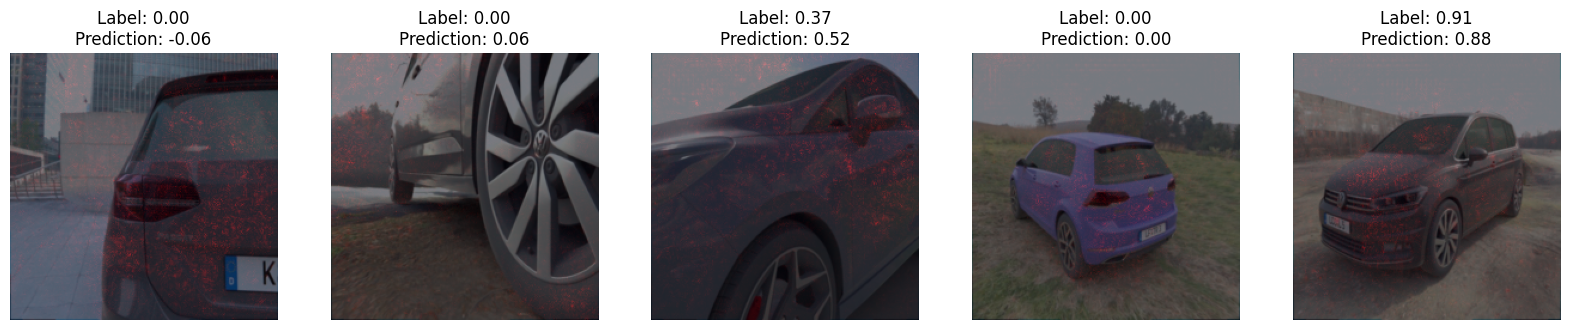

In [16]:
# for first label
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to visualize saliency map overlay with original image, true label, and prediction
def visualize_with_saliency(model, loader, num_images=5):
    model.eval()  # Set model to evaluation mode
    
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)
    
    # Randomly select images
    indices = random.sample(range(images.size(0)), num_images)
    selected_images = images[indices]
    selected_labels = labels[indices]
    
    plt.figure(figsize=(20, 10))
    
    for i, idx in enumerate(indices):
        image = selected_images[i].unsqueeze(0)
        label = selected_labels[i]
        
        image.requires_grad_()
        
        # Forward pass and calculate the gradient
        output = model(image)
        output[:, 0].backward()  # Use the first output for saliency
        
        # Get the gradient and convert to saliency map
        saliency = image.grad.data.abs().squeeze().cpu()
        saliency, _ = saliency.max(dim=0)  # Take the maximum across the color channels
        
        # Normalize the saliency map to range [0, 1]
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        
        # Convert the original image to numpy for visualization
        original_image = image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
        
        # Normalize the original image to range [0, 1]
        original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
        
        # Overlay the saliency map on the original image
        overlay = np.zeros_like(original_image)
        overlay[..., 0] = saliency  # Apply saliency map to the red channel for visibility
        overlay_image = 0.5 * original_image + 0.5 * overlay  # Blend original image with saliency overlay
        
        # Plot the overlay image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(overlay_image)
        plt.axis('off')
        
        # Display label and prediction
        plt.title(f'Label: {label[0].item():.2f}\nPrediction: {output[0, 0].item():.2f}')
    
    plt.show()

# Visualize 5 random images with their label and prediction
visualize_with_saliency(model, test_loader, num_images=5)


### Ideas
1. Use SAM (Segment Anything) to segment cars automatically and then train models for prediction
2. Use less number of classes with high frequency of images
3. classification problem with 0-20 range